<a href="https://colab.research.google.com/github/Bokalli/AI-Lab/blob/master/LAB_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files

uploaded = files.upload()

Saving traffic data.csv to traffic data.csv


<ipython-input-3-18452c9ca1ef>:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range("2025-01-01", periods=500, freq="H")
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Traffic Data Sample:
             timestamp  traffic_flow
0 2025-01-01 00:00:00           152
1 2025-01-01 01:00:00           485
2 2025-01-01 02:00:00           398
3 2025-01-01 03:00:00           320
4 2025-01-01 04:00:00           156
Weather Data Sample:
             timestamp  temperature   humidity
0 2025-01-01 00:00:00    10.970868  38.346972
1 2025-01-01 01:00:00    17.581638  36.047676
2 2025-01-01 02:00:00    23.427061  45.360932
3 2025-01-01 03:00:00    18.166281  73.565735
4 2025-01-01 04:00:00    30.696725  65.577774
Missing values in traffic data: timestamp       0
traffic_flow    0
dtype: int64
Missing values in weather data: timestamp      0
temperature    0
humidity       0
dtype: int64
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.5824 - mae: 0.9416 - val_loss: 0.4762 - val_mae: 0.5980
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8701 - mae: 0.7158 - val_loss: 0.1277 - val_mae: 0.2958
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - lo

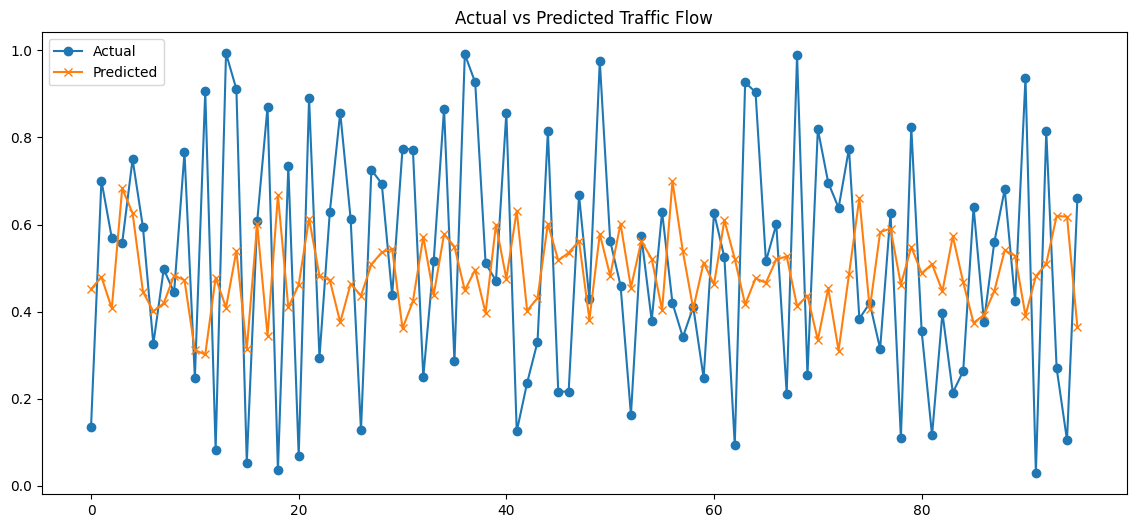

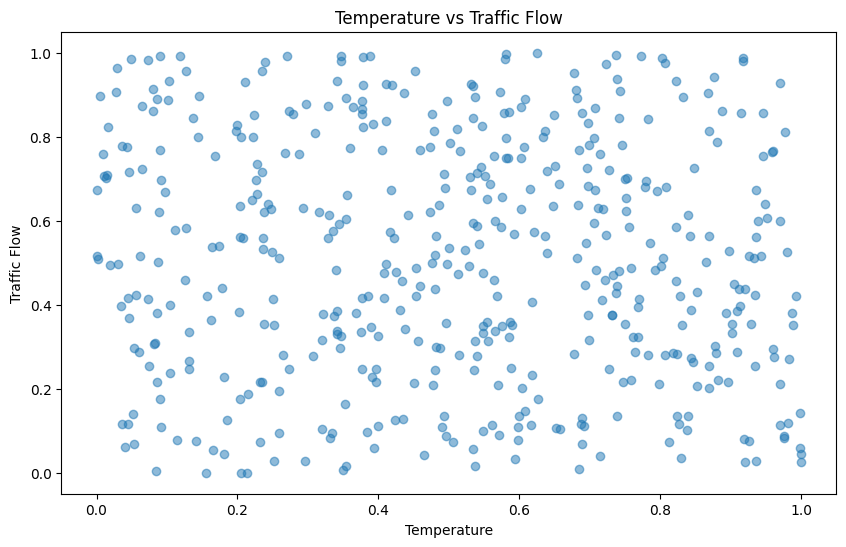

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Step 1: Data Preprocessing
# Simulate Traffic Dataset
np.random.seed(42)
timestamps = pd.date_range("2025-01-01", periods=500, freq="h")
traffic_flow = np.random.randint(50, 500, size=len(timestamps))
traffic_data = pd.DataFrame({"timestamp": timestamps, "traffic_flow": traffic_flow})

# Simulate Weather Dataset
weather_data = pd.DataFrame({
    "timestamp": timestamps,
    "temperature": np.random.uniform(10, 35, size=len(timestamps)),
    "humidity": np.random.uniform(30, 90, size=len(timestamps))
})

# 1. Load and Explore the Dataset
print("Traffic Data Sample:\n", traffic_data.head())
print("Weather Data Sample:\n", weather_data.head())

# Check for missing values
print("Missing values in traffic data:", traffic_data.isnull().sum())
print("Missing values in weather data:", weather_data.isnull().sum())

# 2. Merge Datasets
merged_data = pd.merge(traffic_data, weather_data, on="timestamp")

# 3. Feature Extraction
merged_data["hour"] = merged_data["timestamp"].dt.hour
merged_data["day_of_week"] = merged_data["timestamp"].dt.dayofweek
merged_data["is_weekend"] = (merged_data["day_of_week"] >= 5).astype(int)

# 4. Lag Features
for lag in [1, 2, 24]:
    merged_data[f"lag_{lag}"] = merged_data["traffic_flow"].shift(lag)

# Drop NaN rows created by lag features
merged_data = merged_data.dropna().reset_index(drop=True)

# 5. Normalization
scaler = MinMaxScaler()
numerical_features = ["traffic_flow", "temperature", "humidity", "lag_1", "lag_2", "lag_24"]
merged_data[numerical_features] = scaler.fit_transform(merged_data[numerical_features])

# Step 3: Data Splitting
X = merged_data.drop(columns=["timestamp", "traffic_flow"])
y = merged_data["traffic_flow"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Model Building
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

# 3. Compile the Model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Step 5: Model Training and Evaluation
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# Evaluate the Model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Step 7: Visualization
plt.figure(figsize=(14, 6))
plt.plot(y_test.values[:100], label="Actual", marker='o')
plt.plot(y_pred[:100], label="Predicted", marker='x')
plt.legend()
plt.title("Actual vs Predicted Traffic Flow")
plt.show()

# Weather vs Traffic Visualization
plt.figure(figsize=(10, 6))
plt.scatter(merged_data["temperature"], merged_data["traffic_flow"], alpha=0.5)
plt.title("Temperature vs Traffic Flow")
plt.xlabel("Temperature")
plt.ylabel("Traffic Flow")
plt.show()
